# **SKIN DISEASE CLASSIFICATION**

## ABOUT THE DATASET

HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma


In [1]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

HAM10000_metadata.csv file is the main csv file that includes the data of all training images, the features of which are -
 
1. Lesion_id
2. Image_id
3. Dx
4. Dx_type
5. Age
6. Sex
7. Localization


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/skin-disease-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [4]:

# Reading the data from HAM_metadata.csv
df = pd.read_csv('/content/HAM10000_metadata.csv')

In [5]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [6]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [7]:
df.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

A general statistical analysis of the numerical values of dataset (here : age)

## **Data Cleaning**

In [8]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

The feature 'age' consists of 57 null records. Thus, we need to replace them with the mean of 'age' since dropping 57 records would lead to loss of data.

In [9]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [10]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

Now, the null values have been removed.

In [11]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = os.path.join('..', 'content')

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [12]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

lesion_id      image_id  ...                       cell_type cell_type_idx
0  HAM_0000118  ISIC_0027419  ...  Benign keratosis-like lesions              2
1  HAM_0000118  ISIC_0025030  ...  Benign keratosis-like lesions              2
2  HAM_0002730  ISIC_0026769  ...  Benign keratosis-like lesions              2
3  HAM_0002730  ISIC_0025661  ...  Benign keratosis-like lesions              2
4  HAM_0001466  ISIC_0031633  ...  Benign keratosis-like lesions              2

[5 rows x 10 columns]

## **Image Preprocessing**

In this step, we load all the images into memory. Then, we resize this images because the original dimensions of 450 * 600 * 3 take too long to process in Neural Networks and XAI.

In [13]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

Showcasing some samples of each class of the dataset in the images below:

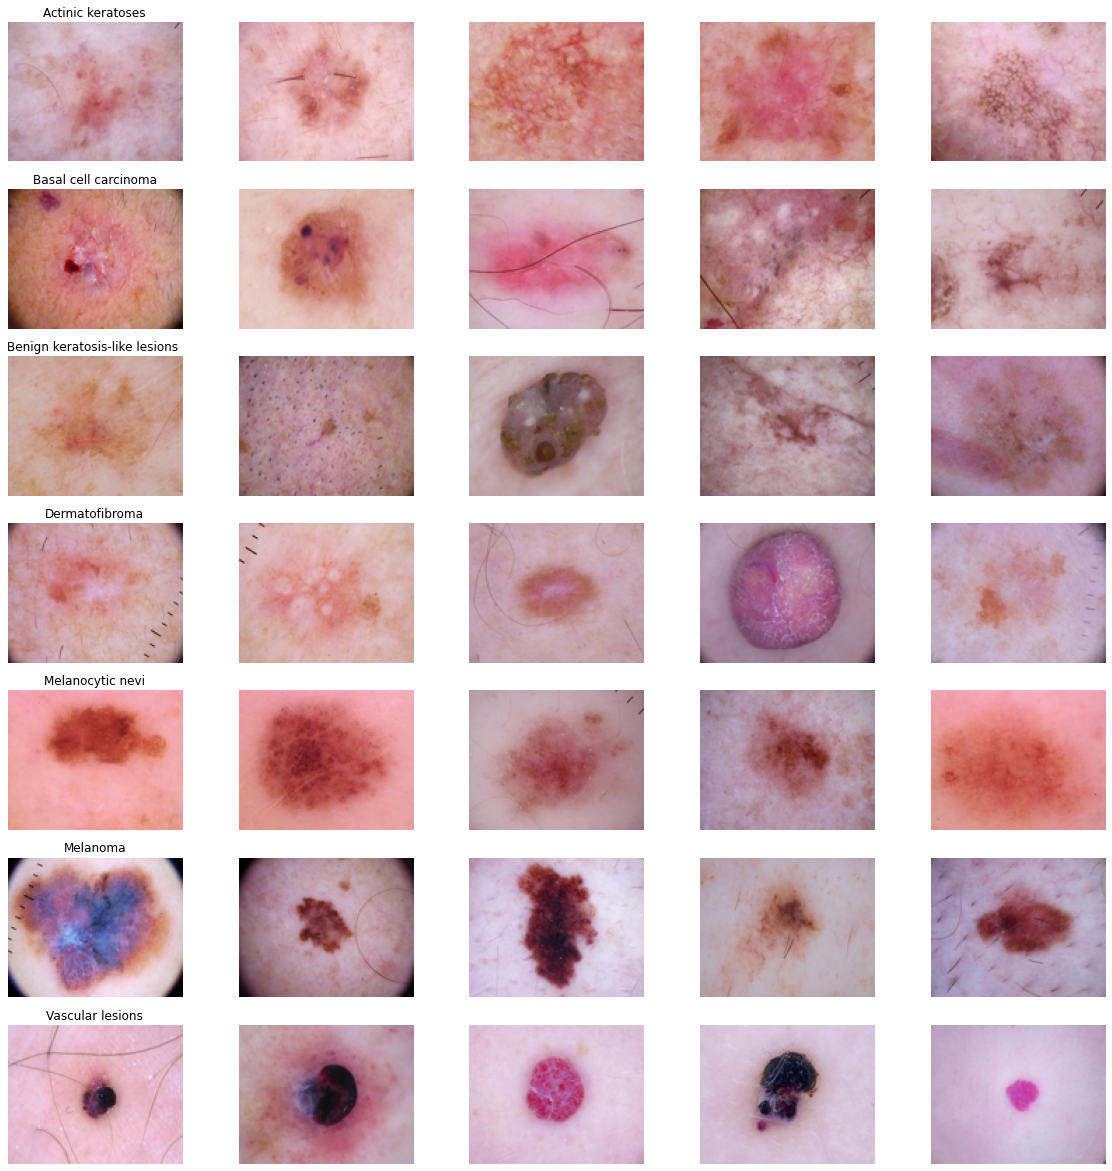

In [14]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [15]:
# See the image size distribution - should just return one row (all images are uniform)
df['image'].map(lambda x: x.shape).value_counts()

(100, 125, 3)    10015
Name: image, dtype: int64

## **Exploratory Data Analysis**

Exploratory data analysis can help detect obvious errors, identify outliers in datasets, understand relationships, unearth important factors, find patterns within data, and provide new insights.

In [21]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

### UNIVARIATE ANALYSIS

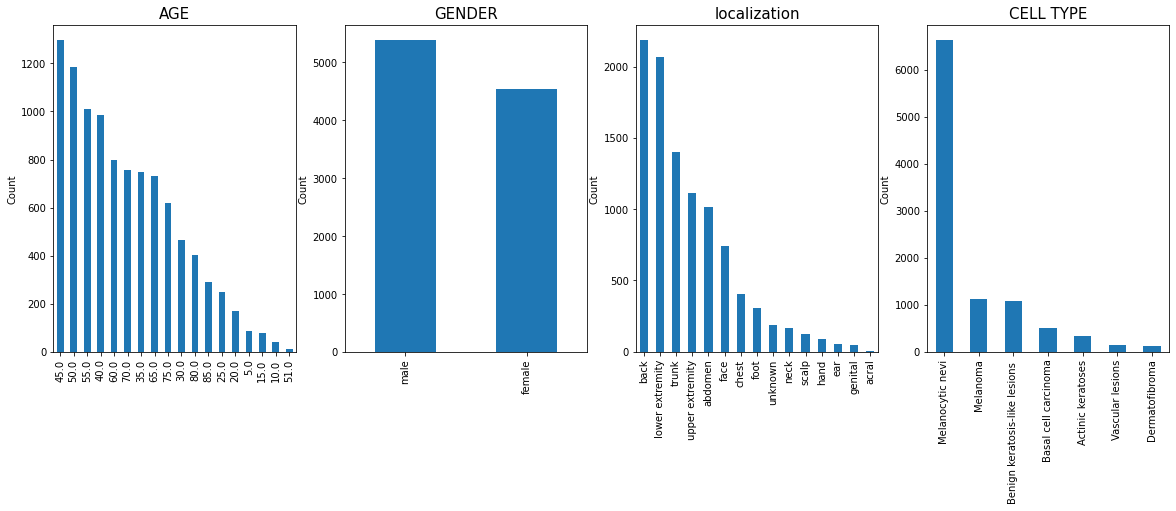

In [22]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

1. Skin diseases are found to be maximum in people aged around 45. Minimum for 10 and below. We also observe that the probability of having skin disease increases with the increase in age.
2. Skin diseases are more prominent in Men as compared to Women and other gender.
3. Skin diseases are more visible on the "back" of the body and least on the "acral surfaces"(such as limbs, fingers, or ears).
4. The most found disease among people is Melanocytic nevi while the least found is Dermatofibroma.

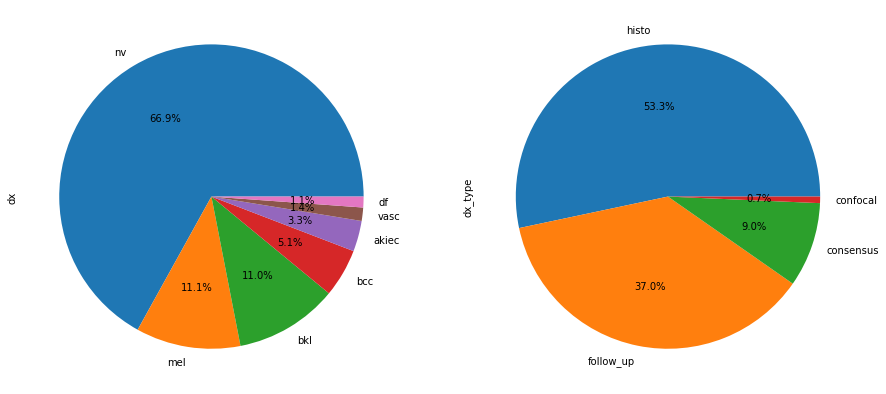

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

1.  Type of skin disease:
    *     nv: Melanocytic nevi - 69.9%
    *     mel: Melanoma - 11.1 %
    *     bkl: Benign keratosis-like lesions - 11.0%
    *     bcc: Basal cell carcinoma - 5.1%
    *     akiec: Actinic keratoses- 3.3%
    *     vasc: Vascular lesions-1.4%
    *     df: Dermatofibroma - 1.1%

2. How the skin disease was discovered:
   * histo - histopathology - 53.3%
   * follow_up - follow up examination - 37.0%
   * consensus - expert consensus - 9.0%
   * confocal - confirmation by in-vivo confocal microscopy - 0.7%

### BIVARIATE ANALYSIS

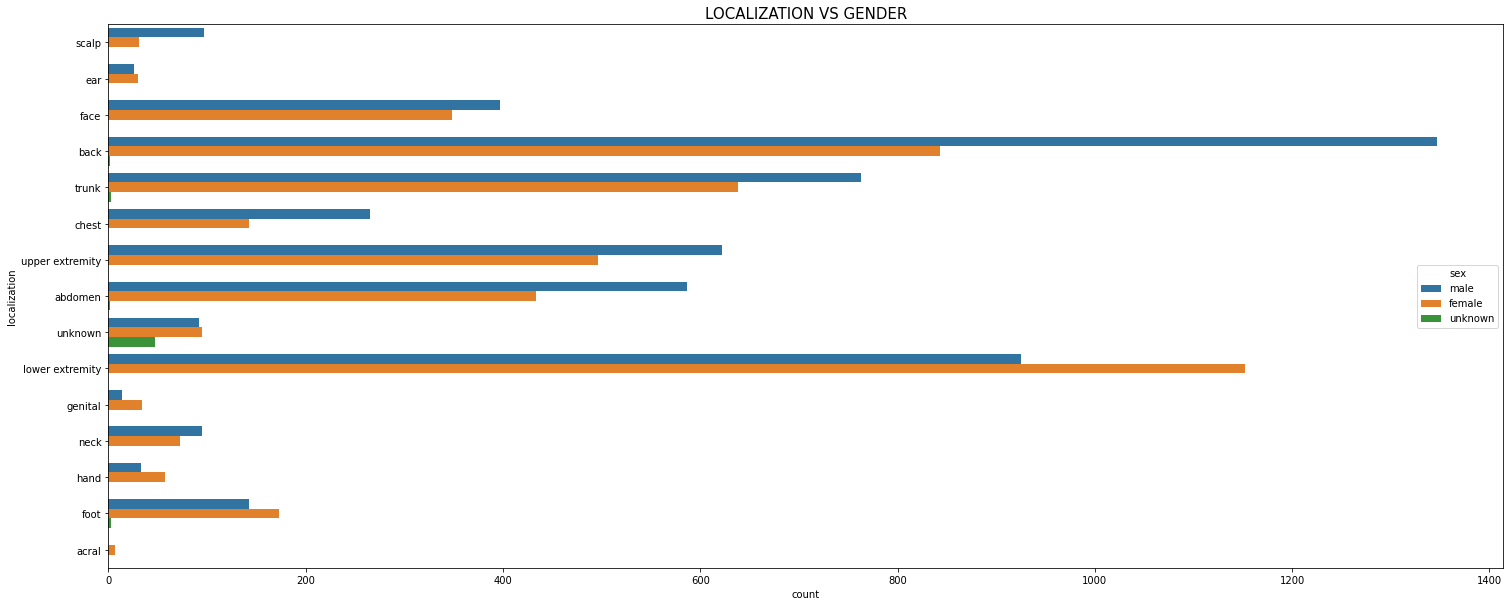

In [ ]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=df)

* Back are is the most affected among people and more prominent in men.
* Infection on Lower extremity of the body is more visible in women.
* Some unknown regions also show infections and it's visible in men, women and other genders.
* The acral surfaces show the least infection cases that too in men only. Other gender groups don't show this kind of infection.


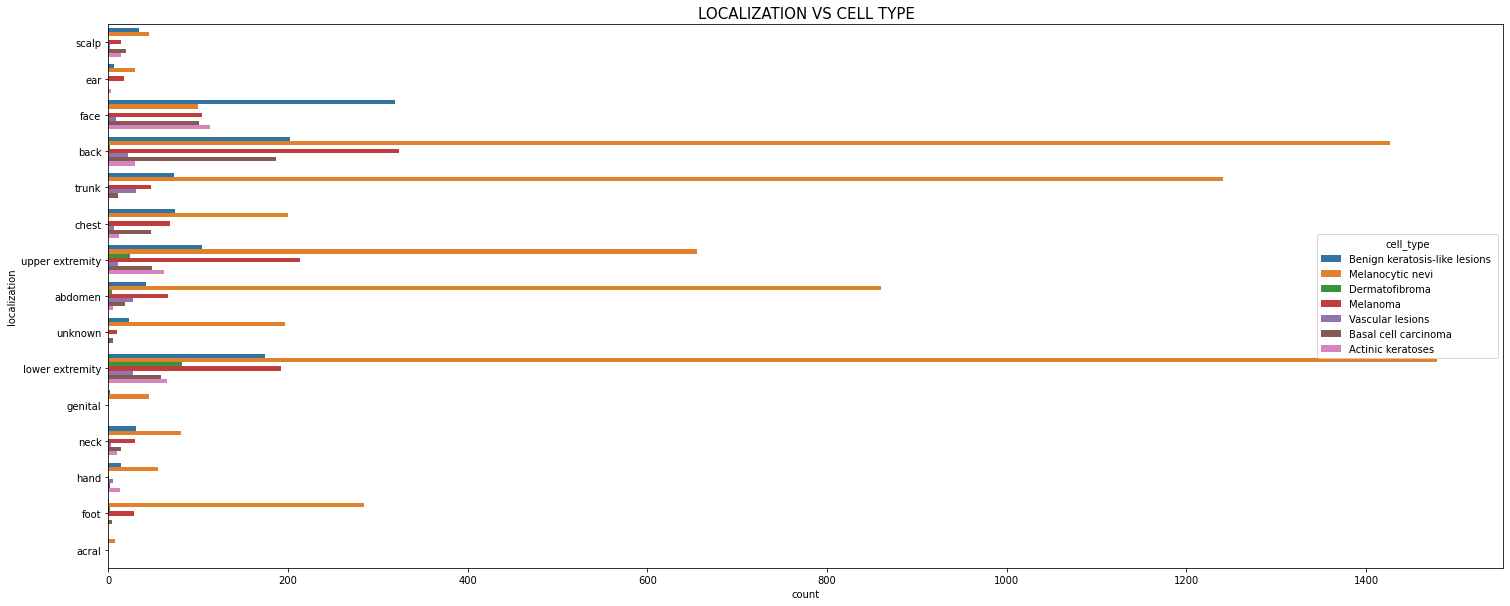

In [ ]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(y='localization', hue='cell_type',data=df)

* The face is infected the most by Benign keratosis-like lesions.
* Body parts(except face) are infected the most by Melanocytic nevi.

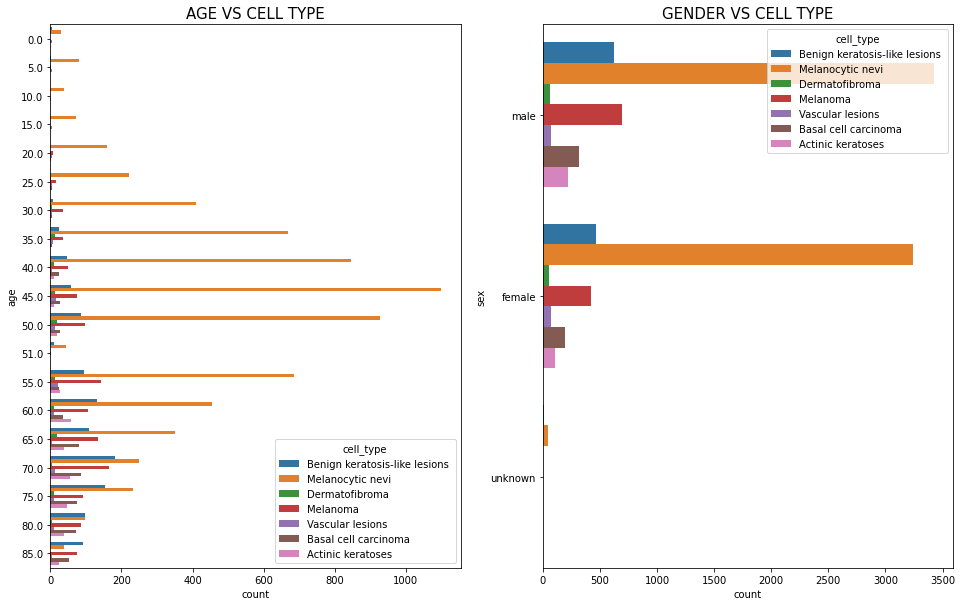

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=df)

1. The age group between 0-75 years is infected the most by Melanocytic nevi. On the other hand, the people aged 80-90 are affected more by Benign keratosis-like lesions.

2. All the gender groups are affected the most by Melanocytic nevi.

In [26]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

## **ANN**

In [ ]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [ ]:
features.head()

lesion_id  ...                                              image
0  HAM_0000118  ...  [[[189, 152, 194], [192, 156, 198], [191, 154,...
1  HAM_0000118  ...  [[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2...
2  HAM_0002730  ...  [[[186, 127, 135], [189, 133, 145], [192, 135,...
3  HAM_0002730  ...  [[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4...
4  HAM_0001466  ...  [[[131, 88, 110], [142, 97, 120], [152, 107, 1...

[5 rows x 10 columns]

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions ',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0], dtype=int32)>)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

In [ ]:
x_train = x_train.reshape(7511,125*100*3)
x_test = x_test.reshape(2504,125*100*3)
print(x_train.shape)
print(x_test.shape)

(7511, 37500)
(2504, 37500)


In [ ]:
# define the keras model
model = Sequential()

model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37500))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train, y_train, batch_size = 10, epochs = 50)

accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

Epoch 1/50
752/752 [==============================] - 4s 5ms/step - loss: 1.0790 - accuracy: 0.6489
Epoch 2/50
752/752 [==============================] - 4s 5ms/step - loss: 0.9096 - accuracy: 0.6817
Epoch 3/50
752/752 [==============================] - 4s 5ms/step - loss: 0.8659 - accuracy: 0.6942
Epoch 4/50
752/752 [==============================] - 4s 5ms/step - loss: 0.8112 - accuracy: 0.7065
Epoch 5/50
752/752 [==============================] - 4s 5ms/step - loss: 0.7976 - accuracy: 0.7079
Epoch 6/50
752/752 [==============================] - 4s 5ms/step - loss: 0.7601 - accuracy: 0.7105
Epoch 7/50
752/752 [==============================] - 4s 5ms/step - loss: 0.7354 - accuracy: 0.7319
Epoch 8/50
752/752 [==============================] - 4s 5ms/step - loss: 0.7017 - accuracy: 0.7405
Epoch 9/50
752/752 [==============================] - 4s 5ms/step - loss: 0.6744 - accuracy: 0.7509
Epoch 10/50
752/752 [==============================] - 4s 5ms/step - loss: 0.6478 - accuracy: 0.7605

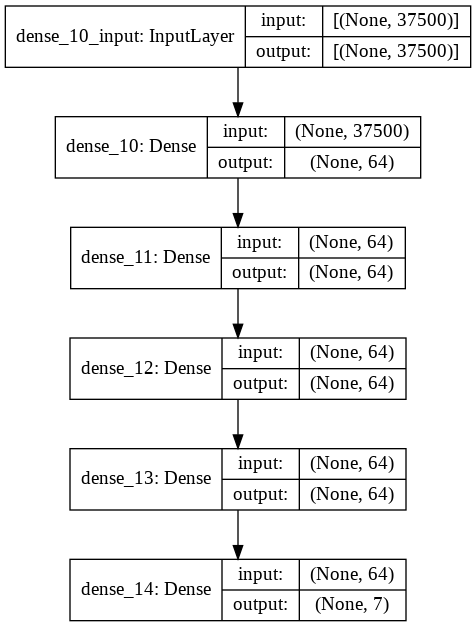

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **CNN**

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*3 -> Flatten -> Dense*2 -> Dropout -> Out
input_shape = (100, 125, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_288 (Conv2D)          (None, 100, 125, 32)      896       
_________________________________________________________________
conv2d_289 (Conv2D)          (None, 100, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 62, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 62, 32)        0         
_________________________________________________________________
conv2d_290 (Conv2D)          (None, 50, 62, 32)        9248      
_________________________________________________________________
conv2d_291 (Conv2D)          (None, 50, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 31, 32)       

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
# Fit the model
epochs = 60
batch_size = 16
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
422/422 [==============================] - 26s 58ms/step - loss: 1.1452 - accuracy: 0.6617 - val_loss: 0.9944 - val_accuracy: 0.6423
Epoch 2/60
422/422 [==============================] - 24s 57ms/step - loss: 0.9554 - accuracy: 0.6731 - val_loss: 0.9746 - val_accuracy: 0.6449
Epoch 3/60
422/422 [==============================] - 24s 57ms/step - loss: 0.8833 - accuracy: 0.6820 - val_loss: 0.9211 - val_accuracy: 0.6689
Epoch 4/60
422/422 [==============================] - 24s 56ms/step - loss: 0.8732 - accuracy: 0.6796 - val_loss: 0.8957 - val_accuracy: 0.6729
Epoch 5/60
422/422 [==============================] - 24s 57ms/step - loss: 0.8059 - accuracy: 0.7064 - val_loss: 0.7978 - val_accuracy: 0.6915
Epoch 6/60
422/422 [==============================] - 24s 57ms/step - loss: 0.7805 - accuracy: 0.7189 - val_loss: 0.8107 - val_accuracy: 0.6928
Epoch 7/60
422/422 [==============================] - 24s 57ms/step - loss: 0.7788 - accuracy: 0.7107 - val_loss: 0.7886 - val_accuracy:

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

The CNN model has been visualised in the model attached above.

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

24/24 [==============================] - 0s 7ms/step - loss: 0.6477 - accuracy: 0.7527
Validation: accuracy = 0.752660  ;  loss_v = 0.647742
Test: accuracy = 0.757188  ;  loss = 0.668491


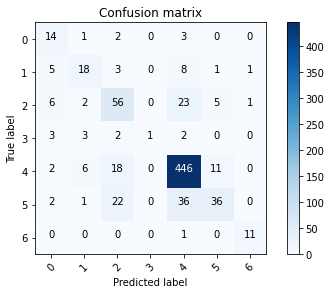

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


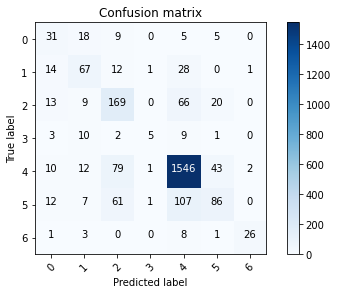

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

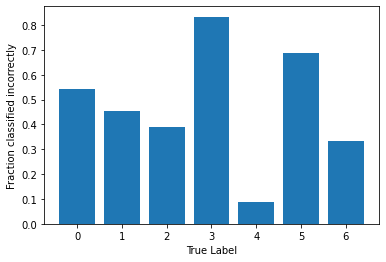

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


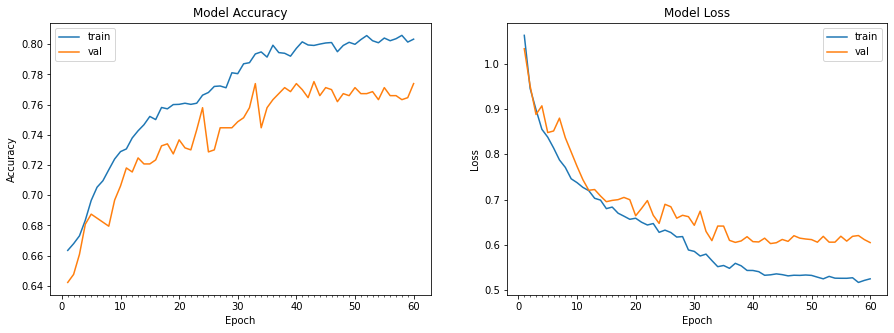

In [ ]:
# Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
plot_model_history(history)

## **Tranfer Learning**

In [ ]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((450,600))))

In [ ]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions ',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0], dtype=int32)>)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))

In [ ]:
print(x_train.shape)

In [ ]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [ ]:
mobile.summary()

In [ ]:
def change_model(model, new_input_shape=(None, 40, 40, 3),custom_objects=None):
    # replace input shape of first layer
    
    config = model.layers[0].get_config()
    config['batch_input_shape']=new_input_shape
    model._layers[0]=model.layers[0].from_config(config)

    # rebuild model architecture by exporting and importing via json
    new_model = tensorflow.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model._layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [ ]:
new_model = change_model(mobile, new_input_shape=[None] + [100,125,3])
new_model.summary()

In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = new_model.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=new_model.input, outputs=predictions)

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])



In [ ]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), 
                              class_weight=class_weights,
                    validation_data=(x_validate,y_validate),steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)


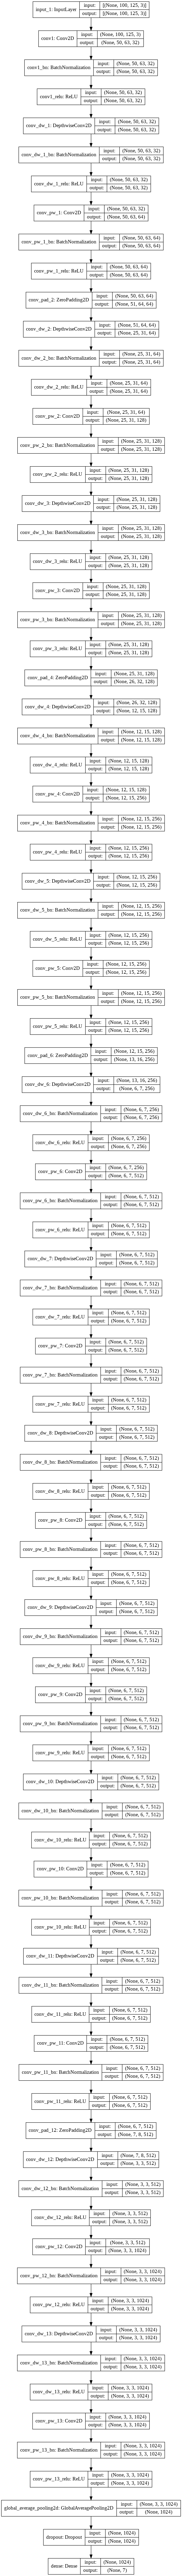

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [ ]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(datagen.flow(x_test,y_test, batch_size=16) )

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

157/157 [==============================] - 35s 217ms/step - loss: 0.6298 - categorical_accuracy: 0.7875 - top_2_accuracy: 0.9149 - top_3_accuracy: 0.9677
val_loss: 0.6298491954803467
val_cat_acc: 0.7875399589538574
val_top_2_acc: 0.9149361252784729
val_top_3_acc: 0.9676517844200134


In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(datagen.flow(x_test,y_test, batch_size=16) 
                        )

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.6491630673408508
val_cat_acc: 0.7867411971092224
val_top_2_acc: 0.9057508111000061
val_top_3_acc: 0.9660543203353882


### Plot the Training Curves

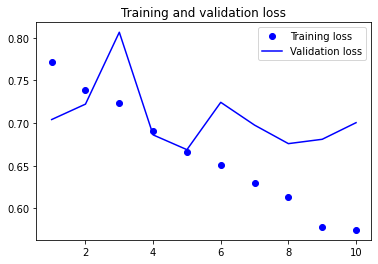

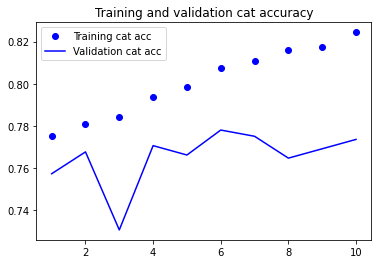

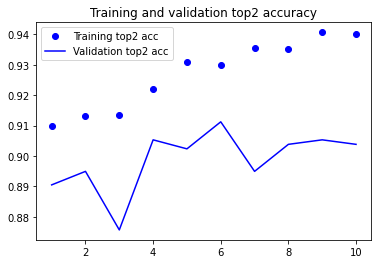

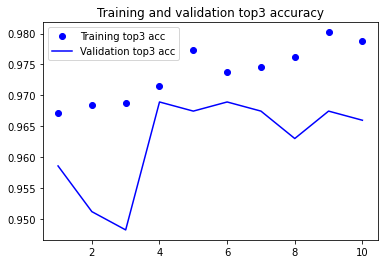

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [ ]:
accuracy = model.evaluate(x_test, y_test,verbose=1)[1]
accuracy_v = model.evaluate(x_validate, y_validate)[1]
print("Validation: accuracy = ", accuracy_v)
print("Test: accuracy = ",accuracy)
model.save("model.h5")

22/22 [==============================] - 6s 280ms/step - loss: 0.6862 - categorical_accuracy: 0.7707 - top_2_accuracy: 0.9053 - top_3_accuracy: 0.9689
Validation: accuracy =  0.7707100510597229
Test: accuracy =  0.7935303449630737


### Create a Confusion Matrix

In [ ]:
# make a prediction
predictions = model.predict_generator(datagen.flow(x_test,y_test, batch_size=16), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


157/157 [==============================] - 31s 194ms/step


In [ ]:
predictions.shape

(2504, 7)

In [ ]:
test_batches = datagen.flow(x_test,y_test, batch_size=16) 
test_batches

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




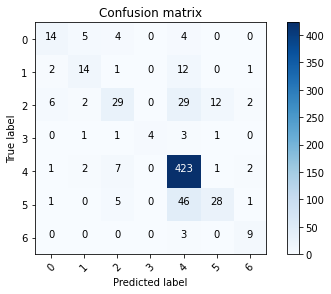

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


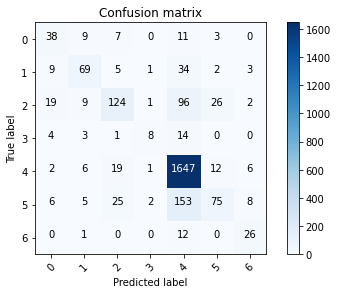

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

### Generate the Classification Report

In [ ]:
y_pred = model.predict(x_test)
y_pred =y_pred>0.5

In [ ]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.45      0.29      0.36        68
         bcc       0.78      0.44      0.56       123
         bkl       0.78      0.39      0.52       277
          df       0.70      0.23      0.35        30
         mel       0.85      0.96      0.91      1693
          nv       0.66      0.20      0.31       274
        vasc       0.59      0.67      0.63        39

   micro avg       0.83      0.76      0.79      2504
   macro avg       0.69      0.46      0.52      2504
weighted avg       0.80      0.76      0.76      2504
 samples avg       0.76      0.76      0.76      2504



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

In [ ]:
model.save("mobilenet_model.h5")

## **XAI**

In [23]:
tile_df = df.copy()

In [24]:
tile_df.drop('lesion_id', inplace=True, axis=1)
tile_df.drop('image_id', inplace=True, axis=1)
tile_df.drop('cell_type', inplace=True, axis=1)
tile_df.drop('path', inplace=True, axis=1)
tile_df.drop('dx', inplace=True, axis=1)
tile_df.head()

dx_type  ...                                              image
0   histo  ...  [[[189, 152, 194], [192, 156, 198], [191, 154,...
1   histo  ...  [[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2...
2   histo  ...  [[[186, 127, 135], [189, 133, 145], [192, 135,...
3   histo  ...  [[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4...
4   histo  ...  [[[131, 88, 110], [142, 97, 120], [152, 107, 1...

[5 rows x 6 columns]

In [27]:
X = tile_df.drop(['cell_type_idx'],axis=1).values
y = tile_df['cell_type_idx'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [ ]:
!pip install alibi

In [ ]:
pip install shap

In [ ]:
import shap
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from alibi.explainers import KernelShap
from scipy.special import logit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

As the dataframe consisted of a few features in the form of strings, we have processed these features by localization one hot method. 

In [28]:
tile_df['localization_onehot'] = tile_df.localization.map({'scalp':0, 'ear':1, 'face':2, 'neck':3,'back':4, 'trunk':5, 'chest':6,
       'upper extremity':7, 'abdomen':8, 'lower extremity':9,
       'genital':10, 'hand':11, 'foot':12, 'acral':13, 'unknown':14})
tile_df.head()

dx_type  ...  localization_onehot
0   histo  ...                    0
1   histo  ...                    0
2   histo  ...                    0
3   histo  ...                    0
4   histo  ...                    1

[5 rows x 7 columns]

In [29]:
tile_df['dx_type_onehot'] = tile_df.dx_type.map({'confocal':0,'consensus':1,'follow_up':2,'histo':3})
tile_df.head()

dx_type   age  ... localization_onehot dx_type_onehot
0   histo  80.0  ...                   0              3
1   histo  80.0  ...                   0              3
2   histo  80.0  ...                   0              3
3   histo  80.0  ...                   0              3
4   histo  75.0  ...                   1              3

[5 rows x 8 columns]

In [30]:
tile_df['gender_male'] = tile_df.sex.map({'female':0, 'male':1, 'unknown':2})
tile_df.head()

dx_type   age   sex  ... localization_onehot  dx_type_onehot gender_male
0   histo  80.0  male  ...                   0               3           1
1   histo  80.0  male  ...                   0               3           1
2   histo  80.0  male  ...                   0               3           1
3   histo  80.0  male  ...                   0               3           1
4   histo  75.0  male  ...                   1               3           1

[5 rows x 9 columns]

In [31]:
tile_df.columns

Index(['dx_type', 'age', 'sex', 'localization', 'cell_type_idx', 'image',
       'localization_onehot', 'dx_type_onehot', 'gender_male'],
      dtype='object')

In [32]:
features = ['age',  'localization_onehot', 'dx_type_onehot','gender_male']

In [33]:
X = tile_df[features]
y = tile_df['cell_type_idx'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [34]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

Creating a XGB Classifier model for the prediction of the type of skin disease using a tabular dataset:

In [35]:
model = XGBClassifier(random_state=1)
model = model.fit(X_train, y_train)

In [36]:
y_pred = model.predict(X_test)

In [37]:
predictions = [round(value) for value in y_pred]

In [38]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.29%


**Shap:**

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  [-0.64985347, -0.27201664, 0.4830587, -1.6700056, 2.5455759, 0.4548538, -1.3232857]


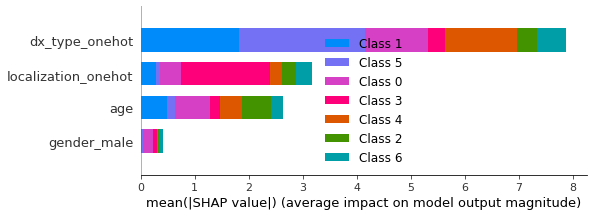

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The summary plot, other than showing us which features are the most important, also show us which feature plays a major role in the prediction of which class.

For example, we observe that the localization plays a major role in predicting whether the disease belongs to class 3. Similarly, dx_type_onehot plays a major role in predicting whether the disease belongs to class 1, 5, etc. 

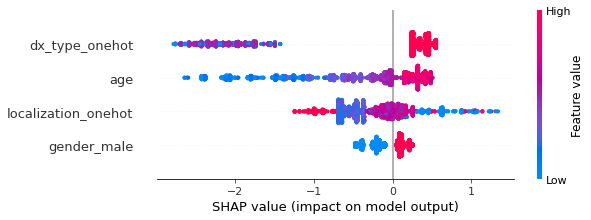

In [ ]:
shap.summary_plot(shap_values[0], X_test)

From this graph, we observe the effect of the different values of each feature on the SHAP value, which is used for prediction. 
For example, we see that the higher values of dx_type_onehot (expert consensus and confirmation via microscopy) are associated with a higher SHAP value. 

In [ ]:
from sklearn.preprocessing import LabelEncoder

## Preprocess training and test target (y) after having performed train-test split
le = LabelEncoder()
y_multi_train = pd.Series(le.fit_transform(y_train))
y_multi_test = pd.Series(le.transform(y_test))

## Check classes
le.classes_

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

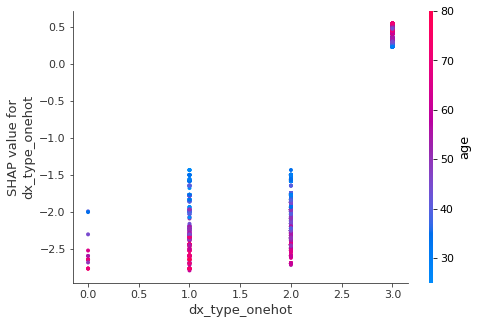

In [ ]:
shap.initjs()
shap.dependence_plot('dx_type_onehot', interaction_index='age',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test)

In this graph, the effect of dx_type_onehot at specific ages is seen on the SHAP value. In congruence to what we observed in the earlier graph, the higher the value for dx_type_onehot (expert consensus or confirmation by microscopy) 

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], X_test.iloc[:100,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][15,:], X_test.iloc[15,:])

Here, we look at a local instance of the dataset. The localisation and type of diagnosis impact the prediction positively due to their positive SHAP value. 
On the other hand, the age and gender of the patient impacts the model negatively. 

**Feature Importance:**

In [ ]:
pip install eli5

     |████████████████████████████████| 112kB 26.0MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [ ]:
eli5.show_weights(model.get_booster(), top=15)

1. We observe that the way the skin disease was diagnosed is extremely important to the prediction of the type of disease.
2. Age as well as the localization of the disease (area of the body the disease is present on) also play major roles in the prediction. 
3. However, we observe that the gender of the patient does not play a major part in the prediction of the model. This shows us that the probability of having a specific disease does not change based on the fact that the patient is male or female, as the innate human biology is the same for either of the sexes.  

In [ ]:
tgt = 6
print('Reference:', y_test[tgt])
print('Predicted:', predictions[tgt])
eli5.show_prediction(model.get_booster(), X_test.iloc[tgt], 
                     feature_names=features, show_feature_values=True)

Reference: 4
Predicted: 4


Here, we have taken a local instance where we observe that the prediction has been made based off of the type of diagnosis and age. 

In [42]:
pip install pdpbox

     |████████████████████████████████| 34.0MB 89kB/s 
     |████████████████████████████████| 13.1MB 241kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758227 sha256=51ae141553d109131b2cd980a866d1353979fb6116f28db66965148f98193463
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [43]:
from pdpbox import pdp, get_dataset, info_plots

In [59]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False, n_cols=3):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

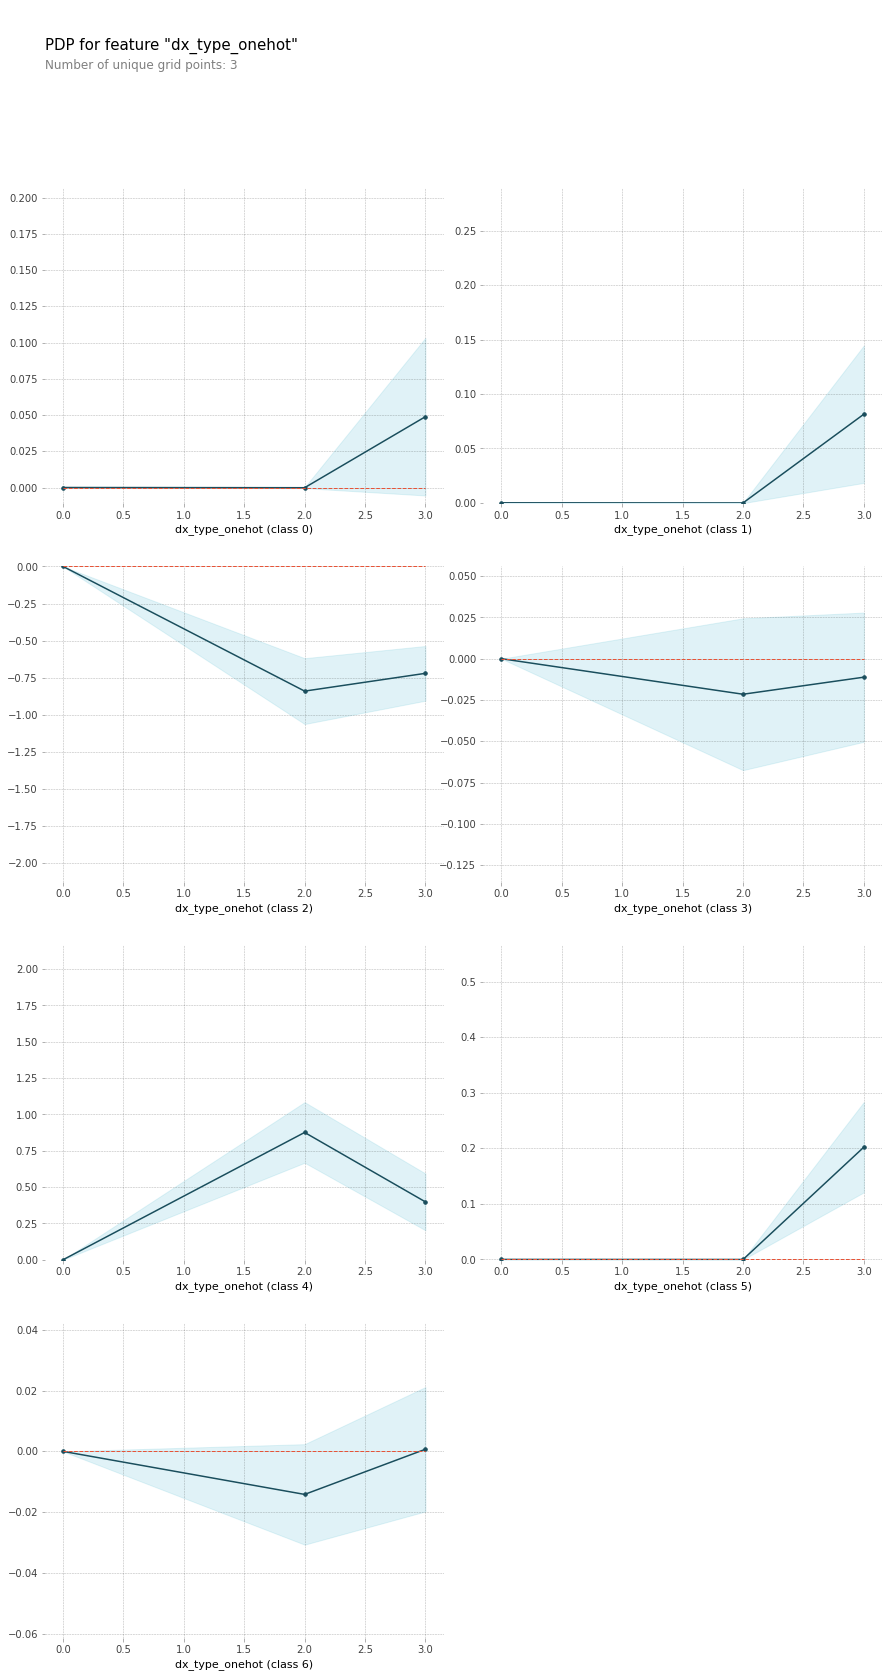

In [60]:
plot_pdp(model, X_train, 'dx_type_onehot')

The PDP (Partial Dependence Plot) shows us the relation between an increase/decrease of one feature to the prediction of the model. 

For example:
In figure 1 (class 0), we observe that the chances of the skin disease belonging to class 0 increases when the value of dx_type_onehot lies between 2 and 3. 
Similarly, in figure 5 (class 4), we observe that the probability of the skin disease belonging to class 4 is extremely high when the value of dx_type_onehot lies between 0 and 2, and decreases comparatively when it lies between 2 and 3.

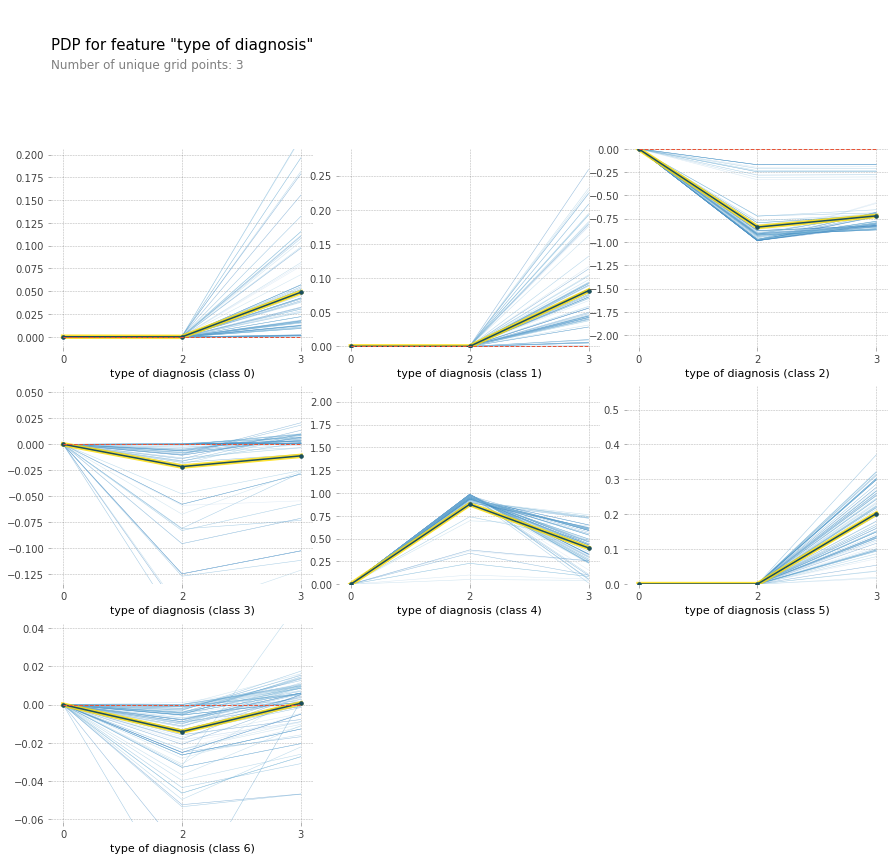

In [66]:
pdp_feat_67_rf = pdp.pdp_isolate(model=model,
                                 dataset=X_train,
                                 model_features=features,
                                 feature='dx_type_onehot')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_feat_67_rf,
                         feature_name='type of diagnosis',
                         center=True,
                         x_quantile=True,
                         ncols=3,
                         plot_lines=True,
                         frac_to_plot=100)

## **XAI Image**

In [ ]:
import skimage.io 
import skimage.segmentation

In [ ]:
np.random.seed(222)

Xi = x_test[3]
preds = model.predict(Xi[np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-5:][::-1] # Save ids of top 5 classes
top_pred_classes

array([4, 2, 3, 5, 1])

In [ ]:
print(y_test[3])

[0. 0. 0. 0. 1. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


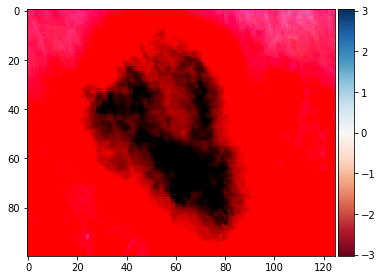

In [ ]:
skimage.io.imshow(Xi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The number of super pixels generated


7

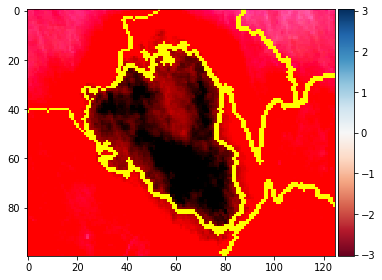

In [ ]:
#Generate segmentation for image
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))
print("The number of super pixels generated")
num_superpixels

In [ ]:
#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 

[1 1 1 1 0 0 1]


In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

(150, 1, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


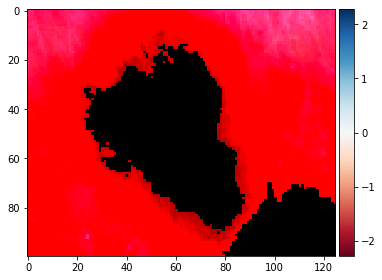

In [ ]:
skimage.io.imshow(perturb_image(Xi,perturbations[0],superpixels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


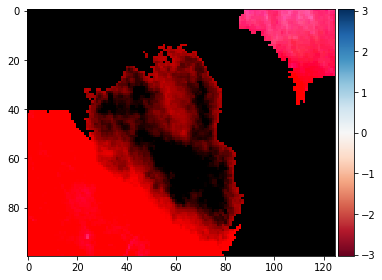

In [ ]:
skimage.io.imshow(perturb_image(Xi,perturbations[11],superpixels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


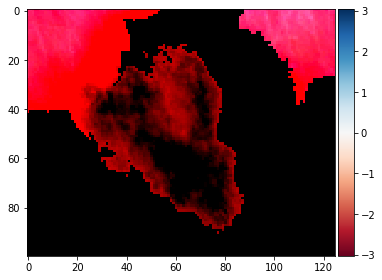

In [ ]:
skimage.io.imshow(perturb_image(Xi,perturbations[2],superpixels))

In [ ]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(150,)
(150,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


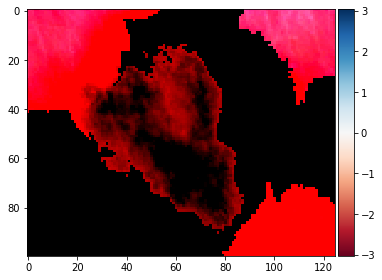

In [ ]:
#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = 4
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi,mask,superpixels))